## Train probe
- Goal: To train MVP probes on activations
    - Maybe make those probes be fancy (mean, attention, softmax)
    - Maybe make those activations be real

### ~~Get activations (Transformerlens)~~

In [1]:
device = "cpu"
# device = "cuda"

In [ ]:
import torch
from transformer_lens import HookedTransformer

# from huggingface_hub import login
# login(token="token_here")

## Small models
# model_name = "tiny-stories-1M"
# model_name = "tiny-stories-3M"
# model_name = "tiny-stories-8M"
# model_name = "tiny-stories-28M"
# model_name = "tiny-stories-33M"
# model_name = "tiny-stories-instruct-33M"

## Large models
model_name = "gpt2-small"
# model_name = "gpt2-medium"
# model_name = "gpt2-xl"
# model_name = "llama-7b"
# model_name = "meta-llama/Llama-3.2-1B"
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "Qwen/Qwen2.5-0.5B"
# model_name = "Qwen/Qwen2.5-1.5B"
# model_name = "Qwen/Qwen2.5-3B"

model = HookedTransformer.from_pretrained(model_name, device=device)
model = model.eval()

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
# Can get logits and activations for one forward pass
test_string = """Mini scule is a species of microhylid frog endemic to Madagascar that was described in 2019. The scientific name of the"""
test_tokens = model.to_tokens(test_string)#.cuda()
print(test_tokens.shape)

logits, cache = model.run_with_cache(test_tokens, remove_batch_dim=True)
print(logits.shape)
print(cache)

torch.Size([1, 27])
torch.Size([1, 27, 50257])
ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out'

In [ ]:
# # Can also autoregressively generate from <path_start> onwards
# test_string = """Mini scule is a species of microhylid frog endemic to Madagascar that was described in 2019. The scientific name of the"""
# test_tokens = model.to_tokens(test_string)#.cuda()
# print(test_tokens.shape)

# predictions = model.generate(
#     test_tokens,
#     max_new_tokens=20,
#     do_sample=True,
#     verbose=False,
#     return_type="tokens",)
# print(model.tokenizer.decode(predictions[0]))

torch.Size([1, 27])
<|endoftext|>Mini scule is a species of microhylid frog endemic to Madagascar that was described in 2019. The scientific name of the species is stratagalidal sculeata.

Locations Honeylatrina 1849,


In [ ]:
# Generate random input using model vocab
test_tokens1 = torch.randint(0, len(model.tokenizer.vocab), (1, 10), device=device)
_, cache1 = model.run_with_cache(test_tokens1, remove_batch_dim=True)

test_tokens2 = torch.randint(0, len(model.tokenizer.vocab), (1, 10), device=device)
_, cache2 = model.run_with_cache(test_tokens2, remove_batch_dim=True)


/home/adrians/Files/LASR/LASR-probe-gen/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded DataFrame with shape: (1000, 4)


In [9]:
df.loc[i]["activations"]

{0: tensor([[ 0.0101,  0.0039, -0.0055,  ..., -0.0576, -0.0037,  0.0341]],
        dtype=torch.float16),
 1: tensor([[-0.0474, -0.0002, -0.0311,  ..., -0.0372, -0.0533,  0.0263]],
        dtype=torch.float16),
 2: tensor([[-0.0299,  0.0315, -0.0266,  ...,  0.0125, -0.0119,  0.0520]],
        dtype=torch.float16),
 3: tensor([[-0.0507,  0.0593, -0.0082,  ...,  0.0437, -0.0486,  0.0455]],
        dtype=torch.float16),
 4: tensor([[ 0.0415,  0.0435,  0.0600,  ...,  0.0980, -0.1110, -0.0176]],
        dtype=torch.float16),
 5: tensor([[ 0.0173, -0.0235,  0.1401,  ...,  0.0807, -0.0933, -0.0087]],
        dtype=torch.float16),
 6: tensor([[-0.0349, -0.0389,  0.1973,  ...,  0.1254, -0.0822, -0.0487]],
        dtype=torch.float16),
 7: tensor([[ 0.0594,  0.0236,  0.2123,  ...,  0.0770, -0.0068, -0.0145]],
        dtype=torch.float16),
 8: tensor([[-0.0038,  0.0758,  0.2610,  ...,  0.1497, -0.1985, -0.0311]],
        dtype=torch.float16),
 9: tensor([[-1.1963e-02,  2.4414e-04,  2.5220e-01,  ..

### Do probe training (Fake activations)

In [23]:
import torch
import numpy as np

# Generate synthetic activation data
np.random.seed(42)
torch.manual_seed(42)

# Simulate activations: (batch_size, seq_len, hidden_dim)
n_train, n_val, n_test = 800, 100, 100
seq_len = 1
hidden_dim = 3072

# Create synthetic data where rejected samples have higher mean activation
def create_synthetic_data(n_samples):
    activations = torch.randn(n_samples, seq_len, hidden_dim)
    labels = torch.randint(0, 2, (n_samples,))
    
    # Make rejected samples (label=1) have slightly higher activations in some dimensions
    rejected_mask = labels == 1
    activations[rejected_mask, :, :100] += 0.5  # Boost first 100 dimensions
    
    return activations, labels.float()

train_activations, train_labels = create_synthetic_data(n_train)
val_activations, val_labels = create_synthetic_data(n_val)
test_activations, test_labels = create_synthetic_data(n_test)


Training linear probe...
Train data: torch.Size([800, 1, 3072]), Val data: torch.Size([100, 1, 3072])
Epoch 1/100, Train Loss: 20.7681, Val Loss: 16.3819
Epoch 2/100, Train Loss: 16.5835, Val Loss: 15.0013
Epoch 3/100, Train Loss: 13.4483, Val Loss: 14.1152
Epoch 4/100, Train Loss: 10.9376, Val Loss: 13.4122
Epoch 5/100, Train Loss: 8.9406, Val Loss: 13.0346
Epoch 6/100, Train Loss: 7.2600, Val Loss: 12.7535
Epoch 7/100, Train Loss: 5.9026, Val Loss: 12.7292
Epoch 8/100, Train Loss: 4.7684, Val Loss: 12.6330
Epoch 9/100, Train Loss: 3.8226, Val Loss: 12.5733
Epoch 10/100, Train Loss: 2.9953, Val Loss: 12.6148
Epoch 11/100, Train Loss: 2.3101, Val Loss: 12.6596
Epoch 12/100, Train Loss: 1.6818, Val Loss: 12.7567
Epoch 13/100, Train Loss: 1.2309, Val Loss: 12.7907
Epoch 14/100, Train Loss: 0.8682, Val Loss: 12.9171
Epoch 15/100, Train Loss: 0.6158, Val Loss: 12.9727
Epoch 16/100, Train Loss: 0.4330, Val Loss: 13.0396
Epoch 17/100, Train Loss: 0.2774, Val Loss: 13.0746
Epoch 18/100, Train

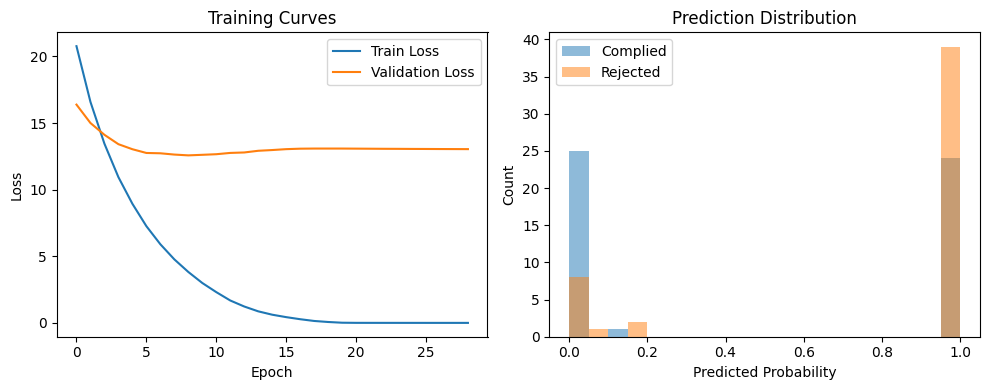

In [16]:
import matplotlib.pyplot as plt

from probe_gen.probe_train import train_probe, evaluate_probe


print("Training linear probe...")
print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

# Train probe
model, train_losses, val_losses = train_probe(
    train_activations=train_activations,
    train_labels=train_labels,
    val_activations=val_activations,
    val_labels=val_labels,
    probe_type="attention",
    learning_rate=5e-3,
    batch_size=16,
    num_epochs=100,
    early_stop_patience=20
)

# Evaluate probe
print("\nEvaluating probe...")
results = evaluate_probe(model, test_activations, test_labels)

print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC-ROC: {results['auc_roc']:.4f}")
print(f"TPR at 1% FPR: {results['tpr_at_1_fpr']:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(results['probabilities'][test_labels.numpy() == 0], alpha=0.5, label='Complied', bins=20)
plt.hist(results['probabilities'][test_labels.numpy() == 1], alpha=0.5, label='Rejected', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Show some values
criterion = nn.BCEWithLogitsLoss()
for i in range(10):
    logits = model(train_activations[i:i+1,:,:])
    print(train_labels[i], logits[0])
    print(torch.sigmoid(logits[0]))
    print(torch.sigmoid(logits[0]) > 0.5)
    print(criterion(logits[0], train_labels[i].float()))
    print()

tensor(1.) tensor(11.7379, grad_fn=<SelectBackward0>)
tensor(1.0000, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(7.9854e-06, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(0.2808, grad_fn=<SelectBackward0>)
tensor(0.5697, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(0.8434, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(0.3314, grad_fn=<SelectBackward0>)
tensor(0.5821, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(0.8725, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(1.) tensor(8.5758, grad_fn=<SelectBackward0>)
tensor(0.9998, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(0.0002, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(1.) tensor(7.6872, grad_fn=<SelectBackward0>)
tensor(0.9995, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(0.0005, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(-5.3685, grad_fn=<SelectBackward0>)
tensor(0.0046, grad_fn=<SigmoidBackward0>)
tensor(False)
tensor(0.0047,

### Do probe training (HF dataset activations)

In [ ]:
# # Code for getting activations and lables for training, using RAW dataset
# import json
# import torch
# import pandas as pd
# from huggingface_hub import hf_hub_download

# # Load the labels dataset
# labels_tensors = []
# with open("../data/refusal/on_policy_raw.jsonl", 'r') as file:
#     for line in file:
#         data = json.loads(line)
#         # We dont want 'ambiguous' labels so we threshold the score
#         if data["scale_labels"] <= 5:
#             labels_tensors.append(torch.tensor([1.0]))
#         else:
#             labels_tensors.append(torch.tensor([0.0]))

# # Download and load the activations dataset
# file_path = hf_hub_download(
#     repo_id="NLie2/anthropic-refusal-activations",
#     filename="dataframe_with_activations.pkl",
#     repo_type="dataset")
# df = pd.read_pickle(file_path)
# print(f"Loaded DataFrame with shape: {df.shape}")

# n_train, n_val, n_test = 800, 100, 100
# seq_len = 1
# hidden_dim = 3072

# # Need to extract activations and labels from the DataFrame
# activations = None
# labels = None
# for i in range(len(df)):
#     if i == 0:
#         activations = df.loc[i]["activations"][0].to(torch.float32)
#         labels = labels_tensors[i]
#     else:
#         activations = torch.cat((activations, df.loc[i]["activations"][0]), dim=0)
#         labels = torch.cat((labels, labels_tensors[i]), dim=0)
# activations = activations.unsqueeze(1)

# # Split the data into train, validation, and test sets
# train_activations, train_labels = activations[:n_train], labels[:n_train]
# val_activations, val_labels = activations[n_train:n_train + n_val], labels[n_train:n_train + n_val]
# test_activations, test_labels = activations[n_train + n_val:n_train + n_val + n_test], labels[n_train + n_val:n_train + n_val + n_test]

In [2]:
# Code for getting activations and lables for training, using raw dataset that is then BALANCED
import json
import torch
import pandas as pd
from huggingface_hub import hf_hub_download

# Load the labels
labels_list = []
with open("../data/refusal/on_policy_raw.jsonl", 'r') as file:
    for line in file:
        data = json.loads(line)
        if data["scale_labels"] <= 5:
            labels_list.append(1.0)
        else:
            labels_list.append(0.0)
labels_tensor = torch.tensor(labels_list)
print("loaded labels")

# Load activations
file_path = hf_hub_download(
    repo_id="NLie2/anthropic-refusal-activations",
    filename="dataframe_with_activations.pkl",
    repo_type="dataset")
df = pd.read_pickle(file_path)
print(f"loaded activations, with shape: {df.shape}")

# Extract all activations
all_activations = []
for i in range(len(df)):
    all_activations.append(df.loc[i]["activations"][0])
activations_tensor = torch.cat(all_activations, dim=0).unsqueeze(1).to(torch.float32)

# Get indices for each label
label_0_indices = (labels_tensor == 0.0).nonzero(as_tuple=True)[0]
label_1_indices = (labels_tensor == 1.0).nonzero(as_tuple=True)[0]
min_class_count = min(len(label_0_indices), len(label_1_indices))

# Subsample both classes to same size
label_0_indices = label_0_indices[:min_class_count]
label_1_indices = label_1_indices[:min_class_count]

# Shuffle indices
label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))]
label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))]

# Compute split sizes
n_total = min_class_count
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

# Split label 0s
train_0 = label_0_indices[:n_train]
val_0 = label_0_indices[n_train:n_train + n_val]
test_0 = label_0_indices[n_train + n_val:]

# Split label 1s
train_1 = label_1_indices[:n_train]
val_1 = label_1_indices[n_train:n_train + n_val]
test_1 = label_1_indices[n_train + n_val:]

# Concatenate splits and shuffle within each
def get_split(indices_0, indices_1):
    indices = torch.cat([indices_0, indices_1])
    indices = indices[torch.randperm(len(indices))]
    return activations_tensor[indices], labels_tensor[indices]

train_activations, train_labels = get_split(train_0, train_1)
val_activations, val_labels = get_split(val_0, val_1)
test_activations, test_labels = get_split(test_0, test_1)

# Confirm balance
print(f"Train: {train_labels.shape[0]} samples, {train_labels.sum()} positives")
print(f"Val:   {val_labels.shape[0]} samples, {val_labels.sum()} positives")
print(f"Test:  {test_labels.shape[0]} samples, {test_labels.sum()} positives")

loaded labels


dataframe_with_activations.pkl:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

loaded activations, with shape: (1000, 4)
Train: 228 samples, 114.0 positives
Val:   28 samples, 14.0 positives
Test:  30 samples, 15.0 positives


In [6]:
# Now actually train the probe on training data and evaluate on test data
import matplotlib.pyplot as plt
from probe_gen.probe_train import train_probe, evaluate_probe

print("Training linear probe...")
print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

# Train probe
model, train_losses, val_losses = train_probe(
    train_activations=train_activations,
    train_labels=train_labels,
    val_activations=val_activations,
    val_labels=val_labels,
    probe_type="mean",
    learning_rate=5e-3,
    batch_size=16,
    num_epochs=100,
    early_stop_patience=20,
    silent=True
)

# Evaluate probe
print("\nEvaluating probe...")
results = evaluate_probe(model, test_activations, test_labels)

print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC-ROC: {results['auc_roc']:.4f}")
print(f"TPR at 1% FPR: {results['tpr_at_1_fpr']:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(results['probabilities'][test_labels.numpy() == 0], alpha=0.5, label='Complied', bins=20)
plt.hist(results['probabilities'][test_labels.numpy() == 1], alpha=0.5, label='Rejected', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()

Training linear probe...
Train data: torch.Size([228, 1, 3072]), Val data: torch.Size([28, 1, 3072])


TypeError: train_probe() got an unexpected keyword argument 'silent'

In [34]:
import torch.nn as nn
# Show some values
criterion = nn.BCEWithLogitsLoss()
for i in range(10):
    logits = model(train_activations[i:i+1,:,:])
    print(train_labels[i], logits[0])
    print(torch.sigmoid(logits[0]))
    print(torch.sigmoid(logits[0]) > 0.5)
    print(criterion(logits[0], train_labels[i].float()))
    print()

tensor(1.) tensor(0.6612, grad_fn=<SelectBackward0>)
tensor(0.6595, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(0.4162, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(-1.0886, grad_fn=<SelectBackward0>)
tensor(0.2519, grad_fn=<SigmoidBackward0>)
tensor(False)
tensor(0.2902, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(-6.9091, grad_fn=<SelectBackward0>)
tensor(0.0010, grad_fn=<SigmoidBackward0>)
tensor(False)
tensor(0.0010, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(-2.8292, grad_fn=<SelectBackward0>)
tensor(0.0558, grad_fn=<SigmoidBackward0>)
tensor(False)
tensor(0.0574, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(-4.3518, grad_fn=<SelectBackward0>)
tensor(0.0127, grad_fn=<SigmoidBackward0>)
tensor(False)
tensor(0.0128, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor(0.) tensor(0.5607, grad_fn=<SelectBackward0>)
tensor(0.6366, grad_fn=<SigmoidBackward0>)
tensor(True)
tensor(1.0123

### Do probe experiments (HF dataset activations)

In [2]:
import json
import torch
import pandas as pd
from huggingface_hub import hf_hub_download
from probe_gen.probe_train import train_probe, evaluate_probe

for layer_num in range(5):
    print(f"\n\nLayer {layer_num}")
    # Load the labels
    labels_list = []
    with open("../data/refusal/on_policy_raw.jsonl", 'r') as file:
        for line in file:
            data = json.loads(line)
            if data["scale_labels"] <= 5:
                labels_list.append(1.0)
            else:
                labels_list.append(0.0)
    labels_tensor = torch.tensor(labels_list)
    print("loaded labels")

    # Load activations
    file_path = hf_hub_download(
        repo_id="NLie2/anthropic-refusal-activations",
        filename="dataframe_with_activations.pkl",
        repo_type="dataset")
    df = pd.read_pickle(file_path)
    print(f"loaded activations, with shape: {df.shape}")

    # Extract all activations
    all_activations = []
    for i in range(len(df)):
        all_activations.append(df.loc[i]["activations"][0])
    activations_tensor = torch.cat(all_activations, dim=0).unsqueeze(1).to(torch.float32)

    # Get indices for each label
    label_0_indices = (labels_tensor == 0.0).nonzero(as_tuple=True)[0]
    label_1_indices = (labels_tensor == 1.0).nonzero(as_tuple=True)[0]
    min_class_count = min(len(label_0_indices), len(label_1_indices))

    # Subsample both classes to same size
    label_0_indices = label_0_indices[:min_class_count]
    label_1_indices = label_1_indices[:min_class_count]

    # Shuffle indices
    label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))]
    label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))]

    # Compute split sizes
    n_total = min_class_count
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    # Split label 0s
    train_0 = label_0_indices[:n_train]
    val_0 = label_0_indices[n_train:n_train + n_val]
    test_0 = label_0_indices[n_train + n_val:]

    # Split label 1s
    train_1 = label_1_indices[:n_train]
    val_1 = label_1_indices[n_train:n_train + n_val]
    test_1 = label_1_indices[n_train + n_val:]

    # Concatenate splits and shuffle within each
    def get_split(indices_0, indices_1):
        indices = torch.cat([indices_0, indices_1])
        indices = indices[torch.randperm(len(indices))]
        return activations_tensor[indices], labels_tensor[indices]

    train_activations, train_labels = get_split(train_0, train_1)
    val_activations, val_labels = get_split(val_0, val_1)
    test_activations, test_labels = get_split(test_0, test_1)

    # Confirm balance
    print(f"Train: {train_labels.shape[0]} samples, {train_labels.sum()} positives")
    print(f"Val:   {val_labels.shape[0]} samples, {val_labels.sum()} positives")
    print(f"Test:  {test_labels.shape[0]} samples, {test_labels.sum()} positives")

    # Now actually train the probe on training data and evaluate on test data

    print("Training linear probe...")
    print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

    # Train probe
    model, train_losses, val_losses = train_probe(
        train_activations=train_activations,
        train_labels=train_labels,
        val_activations=val_activations,
        val_labels=val_labels,
        probe_type="mean",
        learning_rate=5e-3,
        batch_size=16,
        num_epochs=100,
        early_stop_patience=20,
        silent=True
    )

    # Evaluate probe
    print("\nEvaluating probe...")
    results = evaluate_probe(model, test_activations, test_labels)

    print("Test Accuracy, Test AUC-ROC, TPR at 1% FPR")
    print(f"{results['accuracy']:.4f}\t{results['auc_roc']:.4f}\t{results['tpr_at_1_fpr']:.4f}")




Layer 0
loaded labels
loaded activations, with shape: (1000, 4)
Train: 228 samples, 114.0 positives
Val:   28 samples, 14.0 positives
Test:  30 samples, 15.0 positives
Training linear probe...
Train data: torch.Size([228, 1, 3072]), Val data: torch.Size([28, 1, 3072])
Early stopping at epoch 29

Evaluating probe...
Test Accuracy, Test AUC-ROC, TPR at 1% FPR
0.6667	0.7867	0.7333


Layer 1
loaded labels
loaded activations, with shape: (1000, 4)
Train: 228 samples, 114.0 positives
Val:   28 samples, 14.0 positives
Test:  30 samples, 15.0 positives
Training linear probe...
Train data: torch.Size([228, 1, 3072]), Val data: torch.Size([28, 1, 3072])
Early stopping at epoch 22

Evaluating probe...
Test Accuracy, Test AUC-ROC, TPR at 1% FPR
0.7667	0.7778	0.0000


Layer 2
loaded labels
loaded activations, with shape: (1000, 4)


KeyboardInterrupt: 